In [1]:
# https://www.kaggle.com/datasets/ellipticco/elliptic-data-set?resource=download
# The elliptic data set maps bitcoin transfers between entities, both licit and illicit.
# There are 203,769 nodes and 234,355 edges. Nodes are entities and edges are transactions.
# Among the nodes, 2% (4545) are illicit and 21% (42019) are licit. The rest are unknown.
# There are 166 features for each node.
# The first feature is the time step for that node. This represents 
# The next 93 features give information about the transactions made by that node (fees, volume, averages, etc).
# The last 72 features are aggregated from adjacent nodes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graspologic

In [3]:
# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

In [4]:
# number of nodes, edges, features
print("df_features shape:", df_features.shape)
print("df_edgelist shape:", df_edgelist.shape)
print("df_classes shape:", df_classes.shape)

df_features shape: (203769, 167)
df_edgelist shape: (234355, 2)
df_classes shape: (203769, 2)


In [5]:
df_classes.loc[df_classes['class'] == '1', 'class'] = "illicit"
df_classes.loc[df_classes['class'] == '2', 'class'] = "licit"

In [6]:
# renaming columns
df_features.columns = ["id", "time step"] + [f"local_feat_{i}" for i in range(93)] + [f"agg_feat_{i}" for i in range(72)]
df_classes.columns = ["id", "class"]
df_features.head()
df_classes.head()


,id,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,licit
4,230460314,unknown


In [7]:
# adding class data
df = pd.merge(df_features, df_classes, how="inner", on="id")
second_column = df.pop('class')
df.insert(1, 'class', second_column)
df.head()


,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
df_licit_illicit = df[df["class"] != "unknown"]
df_licit_illicit.head()



,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,licit,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,licit,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,licit,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,licit,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [9]:
y = df_licit_illicit.iloc[:, 0:2]
y = y.drop(["id"], axis=1).values
X = df_licit_illicit.drop(["class", "id", "time step"], axis=1).values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = y.ravel()
y = le.fit_transform(y)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=2, stratify=y)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier as knn
model = knn()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9798122353807449
0.9715103793843951


<AxesSubplot: xlabel='time step', ylabel='count'>

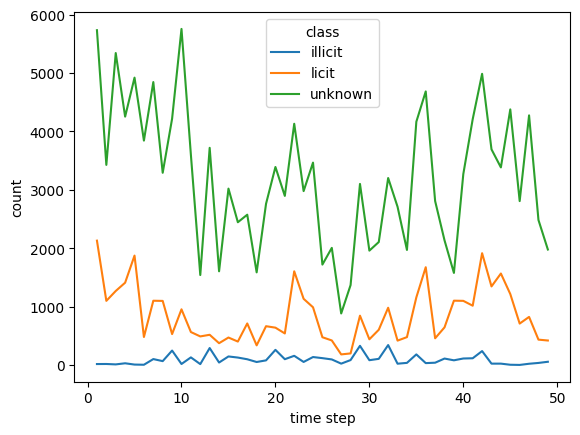

In [12]:
grouped = df.groupby(['time step', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time step', y='count', hue='class', data=grouped)


In [13]:
grouped_illicit = grouped[grouped["class"] == "illicit"]
grouped_illicit.sort_values(by="count", ascending=False)


,time step,class,count
93,32,illicit,342
84,29,illicit,329
36,13,illicit,291
57,20,illicit,260
24,9,illicit,248
123,42,illicit,239
102,35,illicit,182
63,22,illicit,158
42,15,illicit,147
69,24,illicit,137


<AxesSubplot: xlabel='time step', ylabel='count'>

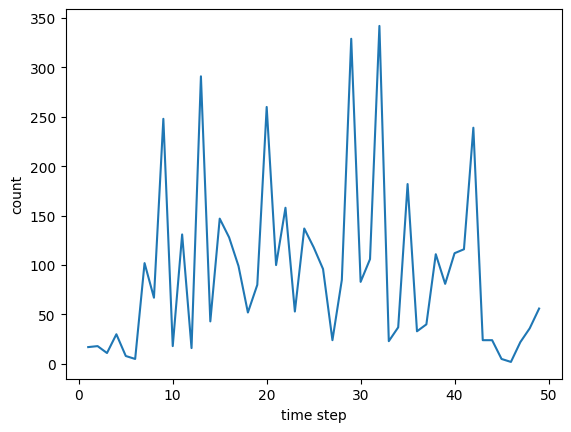

In [14]:
sns.lineplot(x='time step', y='count', data=grouped_illicit)


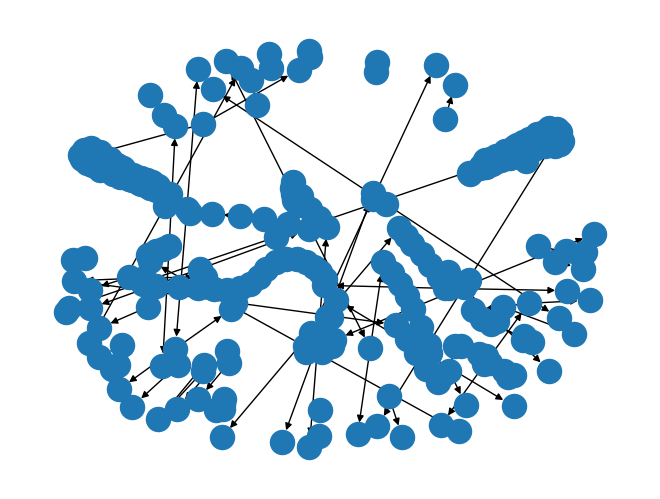

In [15]:
illicit_ids_32 = df.loc[(df['time step'] == 32) & (df['class'] == 'illicit'), 'id']
illicit_edges_32 = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids_32)]

graph_32 = nx.from_pandas_edgelist(illicit_edges_32, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph_32)
nx.draw(graph_32, with_labels=False, pos=pos)

<AxesSubplot: >

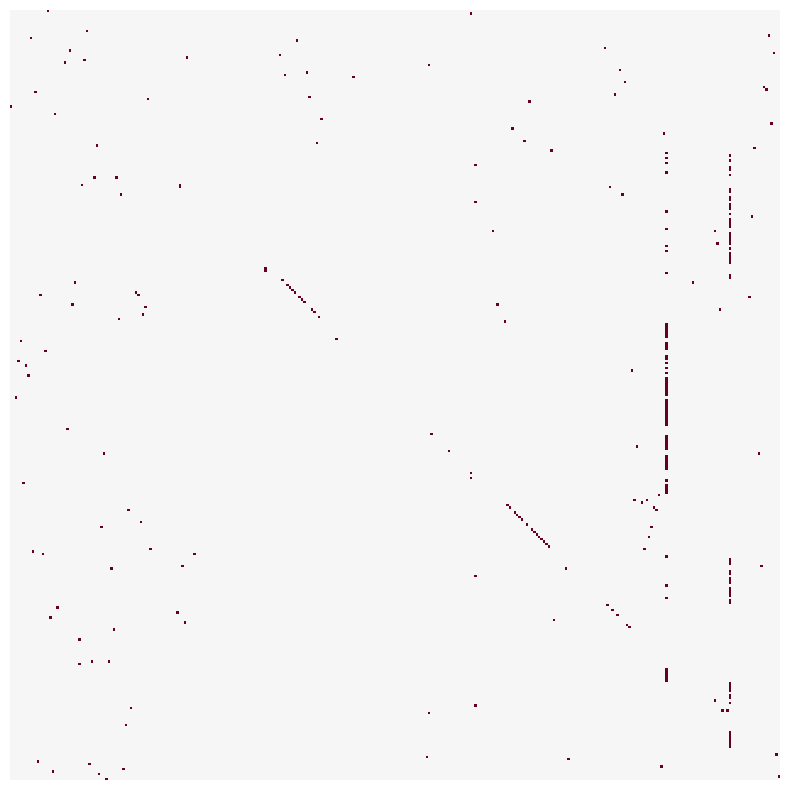

In [16]:
from graspologic.plot import heatmap
heatmap(graph_32, cbar=False)

In [22]:
nodelist = list(graph_32.nodes)
A = nx.to_numpy_array(graph_32, nodelist=nodelist)

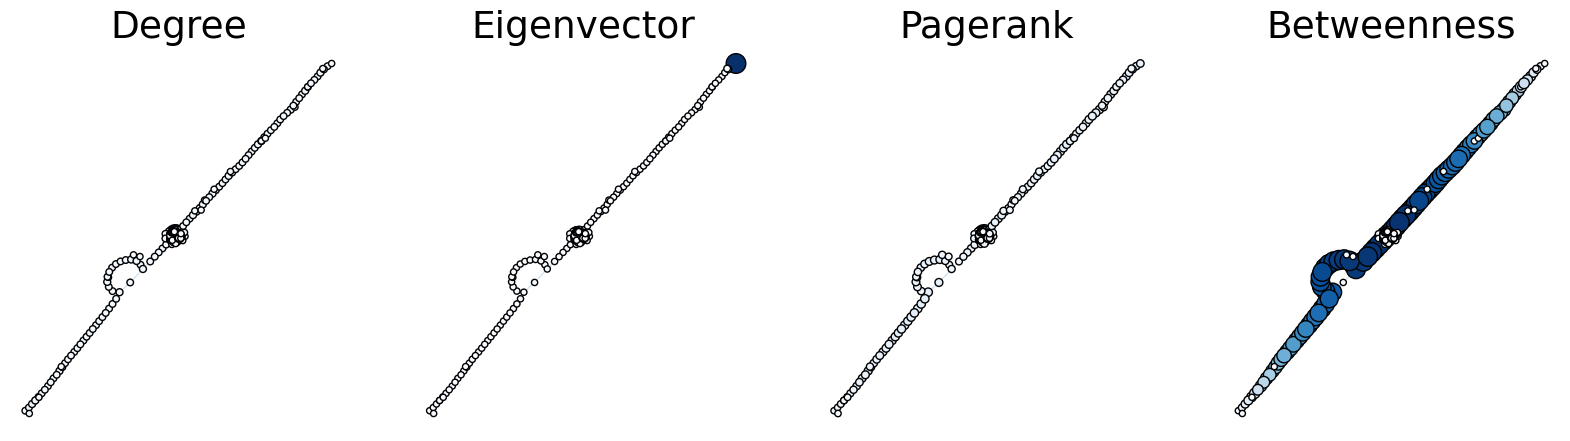

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors

node_data = pd.DataFrame(index=graph_32.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(graph_32)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(graph_32, max_iter=6000))
node_data["pagerank"] = node_data.index.map(nx.pagerank(graph_32))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(graph_32))

pos = nx.kamada_kawai_layout(graph_32)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, "betweenness", ax)

fig.set_facecolor("w")



ValueError: Maximum allowed size exceeded

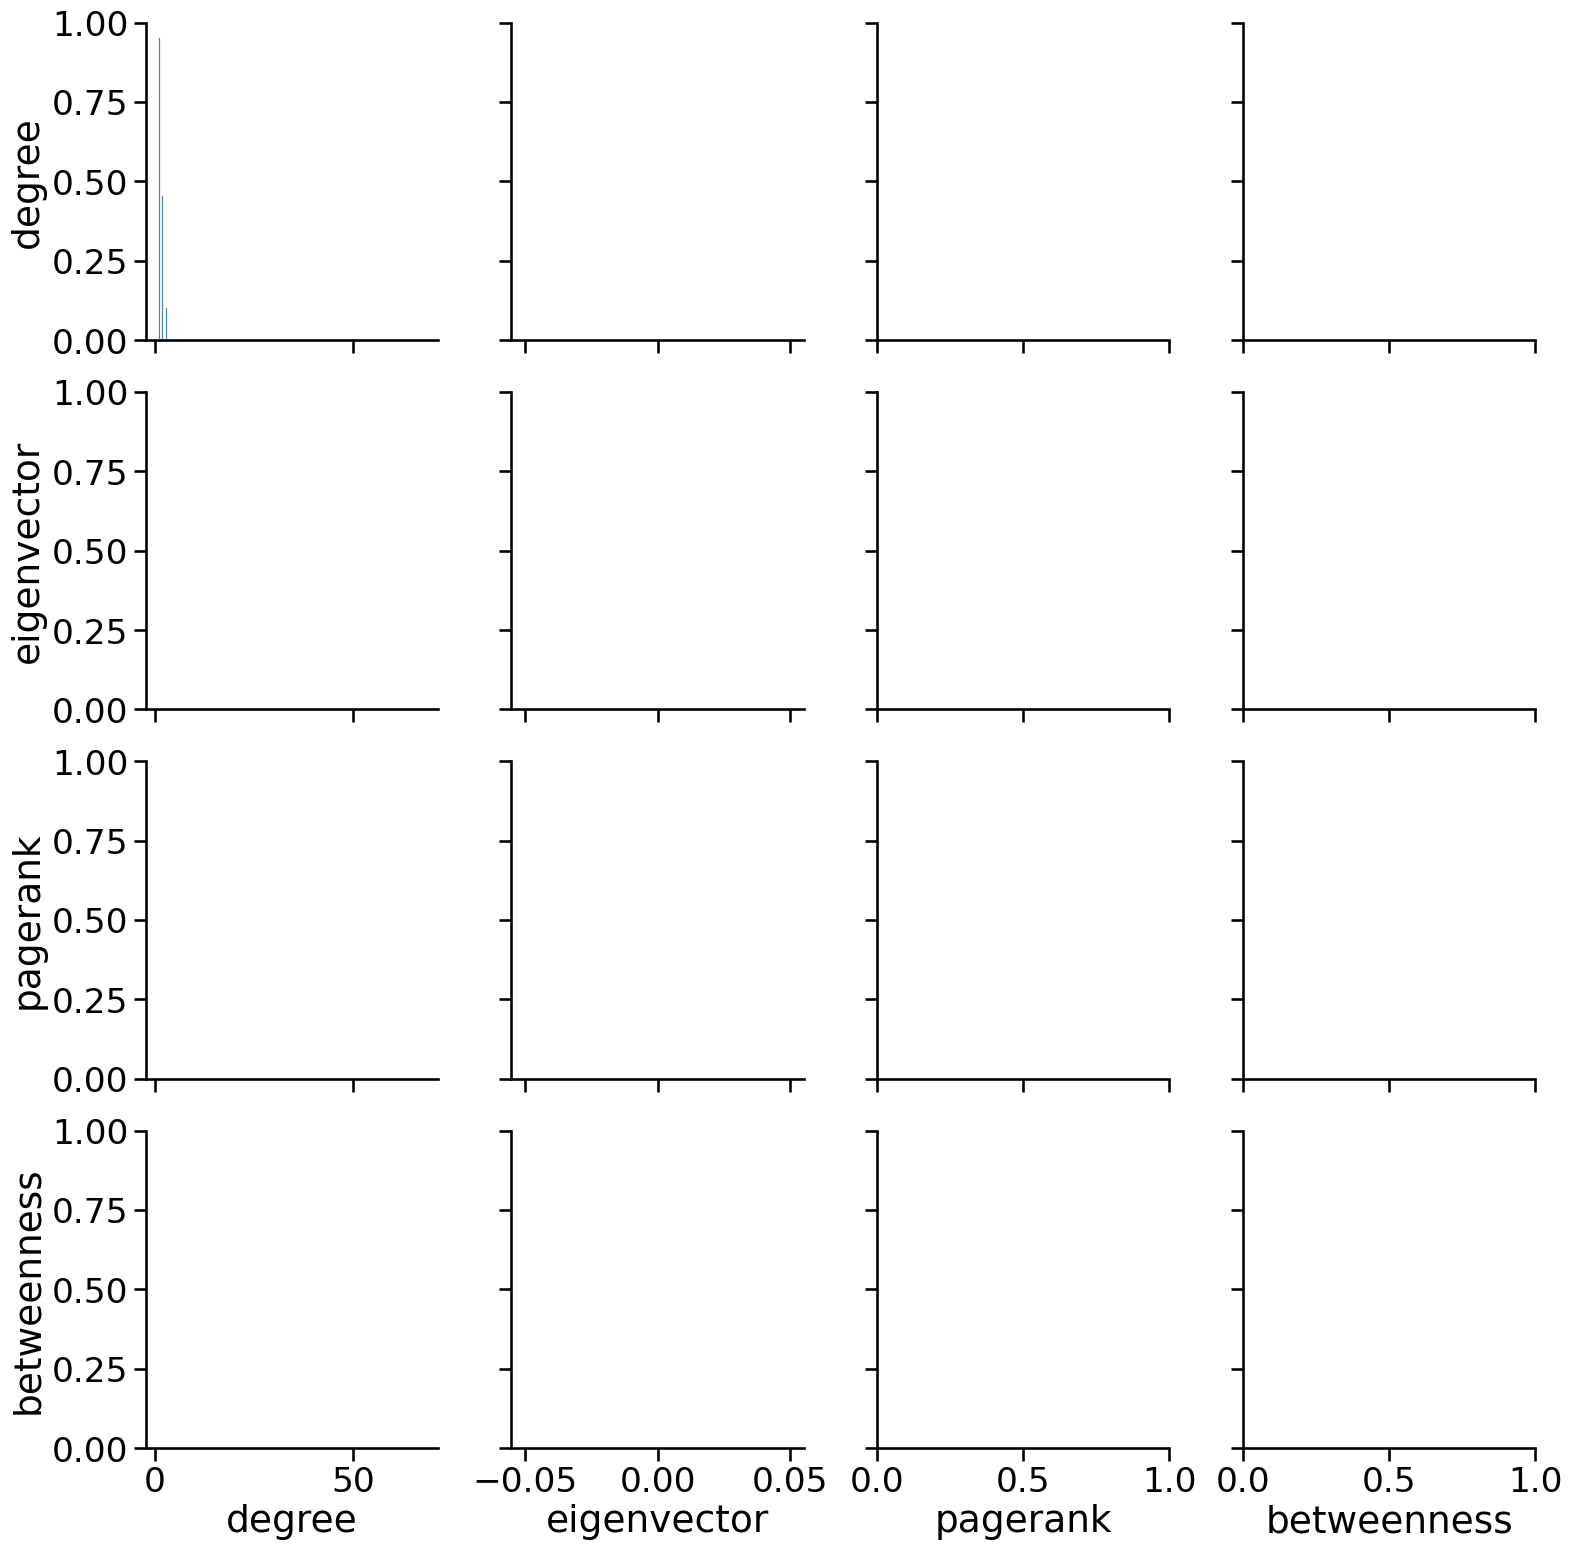

In [29]:
sns.pairplot(node_data, vars=['degree', 'eigenvector', 'pagerank', 'betweenness'], height=4)

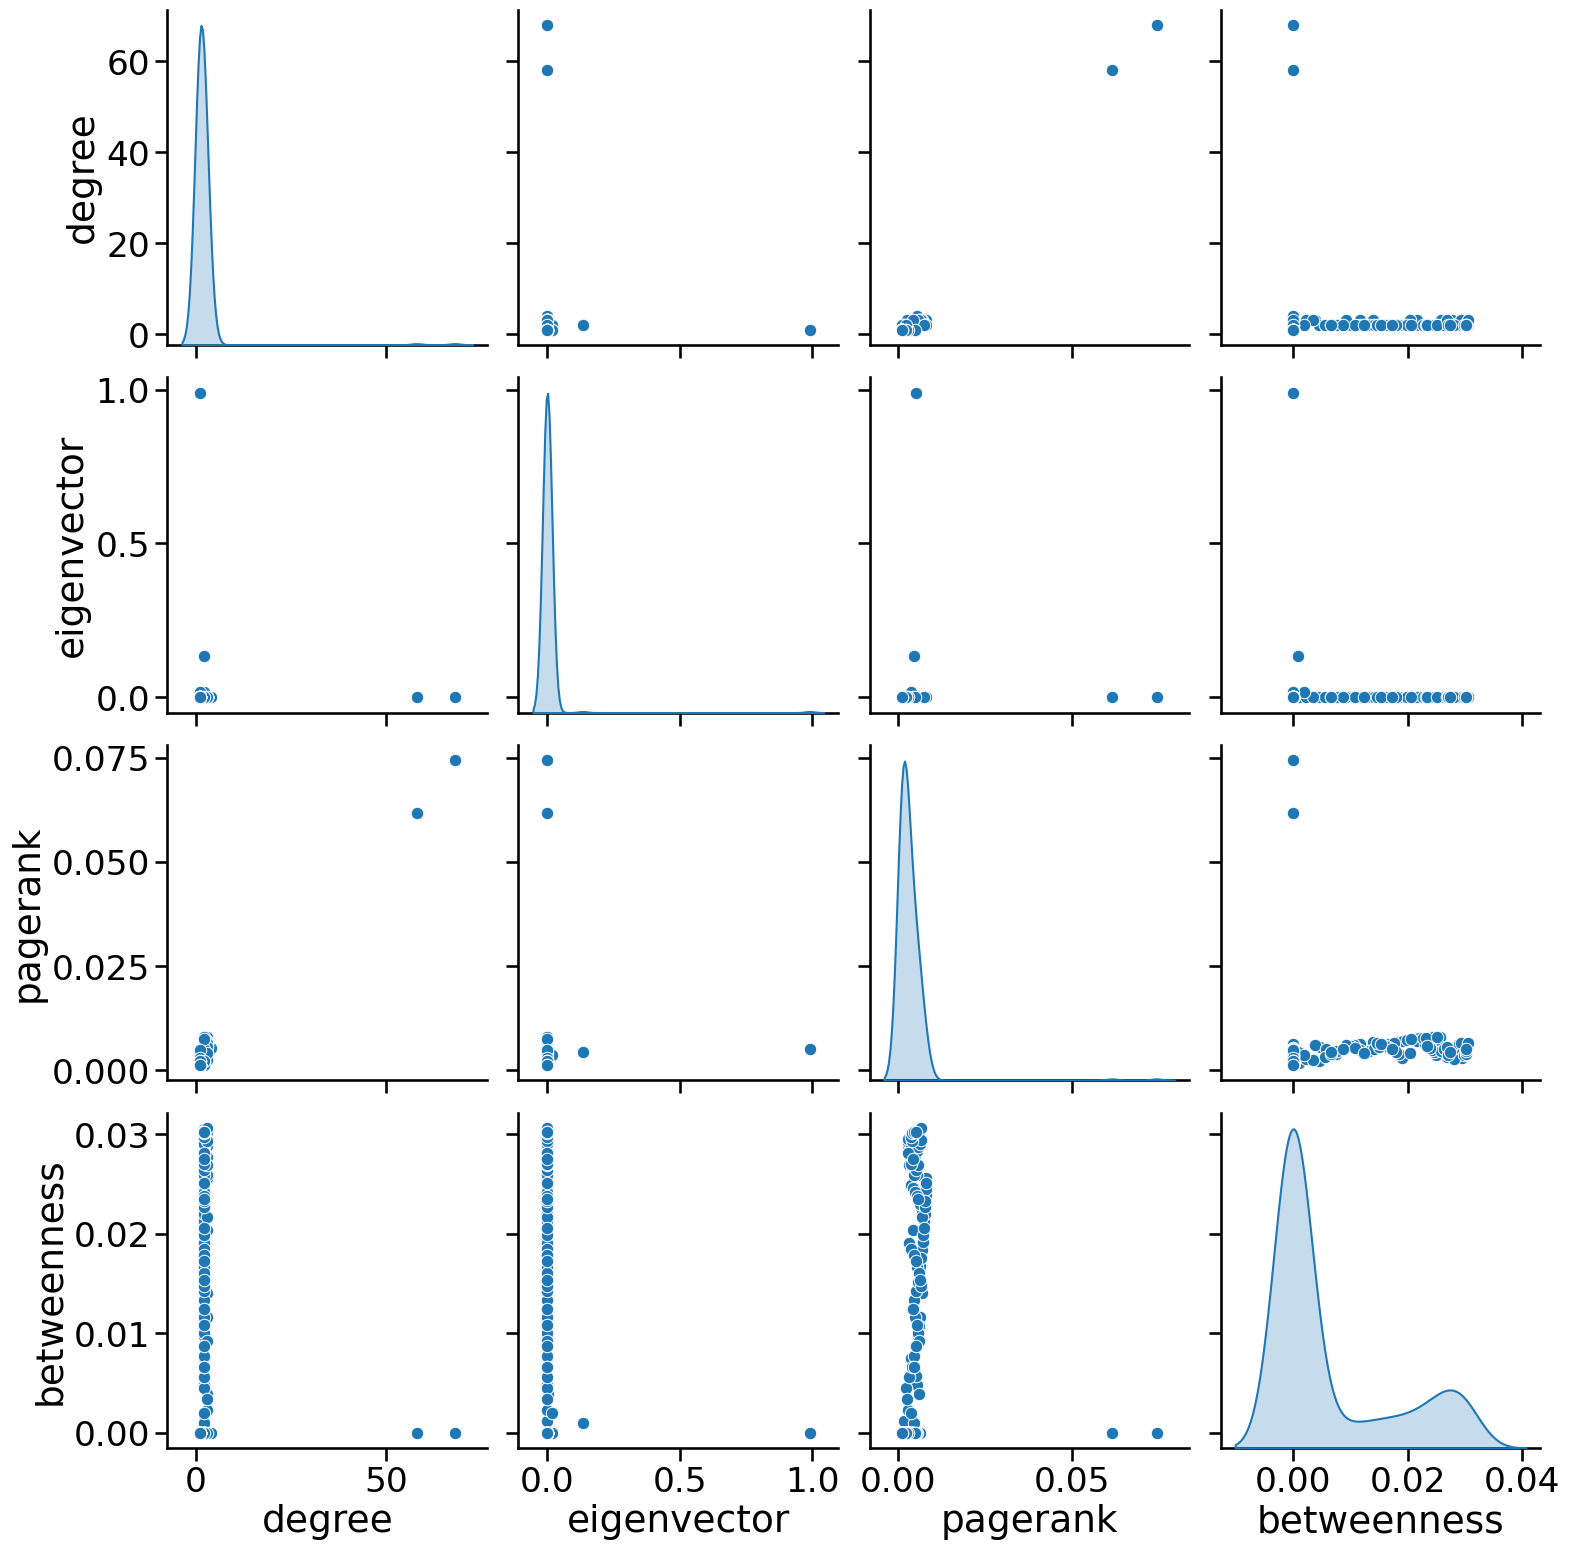

In [32]:
sns.pairplot(node_data, vars=['degree', 'eigenvector', 'pagerank', 'betweenness'], height=4, diag_kind="kde")